In [54]:
from src.final_product import PlantForecast
import src.cross_validation as cv
import src.modis_preprocessing as mpre

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import os
import time
import gdal

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 22})


## Initiate the class PlantForecast()

```python
pf = PlantForecast()

pf.load_metadata()

pf.load_ndvi(preloaded=True)

pf.load_weather(preloaded=True)

pf.merge_modis_weather()
```

In [55]:
pf = PlantForecast()

In [56]:
pf.load_metadata()
pf.load_ndvi(preloaded=True)
pf.load_weather(preloaded=True)
pf.merge_modis_weather(longterm=365)

Preloading from path: preloaded_data/2000_2017_ndvi.csv
Preloading from path: preloaded_data/2000_2017_weather.csv
You are lagging for 365 days


## pf.idfinder['station_code'] 
-A handy dictionary tool where you can pass in a station code and get an array with [lat,long,elevation,state], so you don't get too lost ;)

In [59]:
pf.idfinder['AEM00041217']

array([24.433, 54.651, 26.8, 'ABU'], dtype=object)

## Train/Test Split
You can change what years you want to train/test split on. 

In [31]:
train_df, test_df=pf.train_test_split_by_year(test_years=[2010,2011,2012,2013,2014,2015,2016,2017],train_years=list(range(2000,2015)))

In [32]:
train_df.head()

,PRCP,SNOW,SNOWD,TMAX,TMIN,LT_precip,LT_snow,LT_snowd,LT_tmax,LT_tmin,NDVI,intercept
2000-03-05,23.6209,7.9926,162.765,143.783,-13.0523,14.9744,7.46165,120.902,122.668,-31.5025,2652.74,1
2000-03-21,23.0775,15.5269,184.975,141.692,-16.2122,16.575,9.05479,133.558,126.426,-28.4822,2808.49,1
2000-04-06,37.0565,10.7587,175.614,168.873,17.915,19.9534,9.33585,140.495,133.427,-20.829,2901.39,1
2000-04-22,15.6428,1.64556,118.099,209.941,39.7163,19.343,8.24696,137.324,144.261,-12.2562,3185.68,1
2000-05-08,25.9922,0.96907,72.7078,246.2,73.991,20.1677,7.34428,129.31,156.905,-1.55891,3323.33,1


In [33]:
X_train= train_df[['PRCP','SNOW','SNOWD','TMAX','TMIN','LT_precip','LT_snow','LT_snowd', 'LT_tmax','LT_tmin','intercept']]
y_train = train_df[['NDVI']].values.reshape(-1,)

In [34]:
X_test= test_df[['PRCP','SNOW','SNOWD','TMAX','TMIN','LT_precip','LT_snow','LT_snowd', 'LT_tmax','LT_tmin','intercept']]
y_test = test_df[['NDVI']].values.reshape(-1,)

In [35]:
gbr = None
gbr = GradientBoostingRegressor(loss='ls', n_estimators=1000,
                                  learning_rate=0.001,max_depth=50,subsample=0.8)
gbr.fit(X_train,y_train)
gbr_pred=gbr.predict(X_test)
gbr_score=gbr.score(X_test,y_test)
gbr_mse = mean_squared_error(y_test, gbr_pred)

In [36]:
rf = None
rf= RandomForestRegressor()
rf.fit(X_train,y_train)
rf_pred= rf.predict(X_test)
rf_score=rf.score(X_test,y_test)
rf_mse = mean_squared_error(y_test, rf_pred)

In [37]:
lin= None
lin= LinearRegression()
lin.fit(X_train,y_train)
lin_pred= lin.predict(X_test)
lin_score = lin.score(X_test,y_test)
lin_mse = mean_squared_error(y_test, lin_pred)

In [38]:
ridge = None
ridge= Ridge(alpha=0.1)
ridge.fit(X_train,y_train)
ridge_pred= ridge.predict(X_test)
ridge_score=ridge.score(X_test,y_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)

In [39]:
lasso=None
lasso = Lasso(alpha=.5)
lasso.fit(X_train,y_train)
lasso_pred=lasso.predict(X_test)
lasso_score= lasso.score(X_test,y_test)
lasso_mse = mean_squared_error(y_test, lasso_pred)

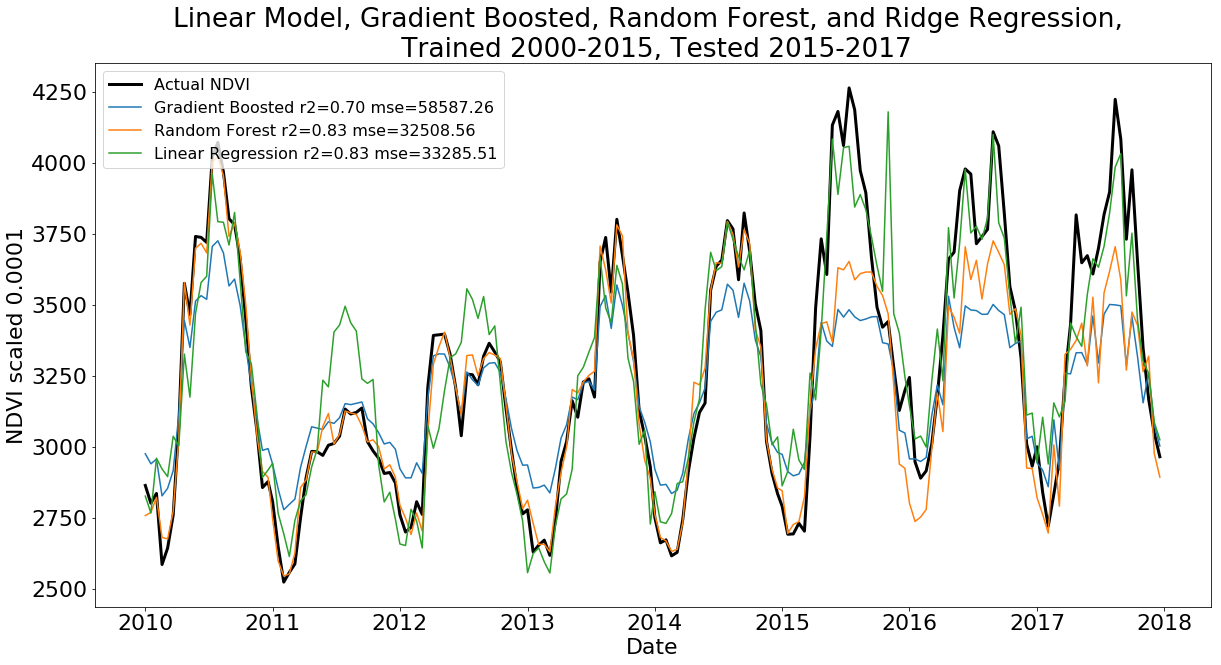

In [51]:
matplotlib.rcParams.update({'font.size': 22})

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(X_test.index,y_test, label='Actual NDVI', color='Black', linewidth=3)
ax.plot(X_test.index, gbr_pred, label=f'Gradient Boosted r2={gbr_score:.2f} mse={gbr_mse:.2f}', color='C0')
ax.plot(X_test.index, rf_pred, label=f'Random Forest r2={rf_score:.2f} mse={rf_mse:.2f}', color='C1')
ax.plot(X_test.index, lin_pred, label=f'Linear Regression r2={lin_score:.2f} mse={lin_mse:.2f}', color='C2')
#ax.plot(X_test.index, ridge_pred, label=f'Ridge Regression r2={ridge_score:.2f} mse={ridge_mse:.2f}', color='red')
#ax.plot(X_test.index, lasso_pred, label=f'Lasso Regression Predicted NDVI r2:{lasso_score}', color='blue')

#ax2 = ax.twinx()
#ax2.plot(X_test.index, X_test['TMAX'], color='Red',linestyle=':')
#ax2.plot(X_test.index, X_test['TMIN'], color='teal',linestyle=':')

#ax3= ax.twinx()
#ax3.bar(X_test.index, -X_test['PRCP'].astype(float), 3,label='precipitation',color='blue')
#ax3.bar(X_test.index, -X_test['SNOW'].astype(float), 3,label='snow',color='yellow')
#ax3.set_ylim(-200,0)


ax.set_title('Linear Model, Gradient Boosted, Random Forest, and Ridge Regression, \n Trained 2000-2015, Tested 2015-2017')
ax.set_ylabel('NDVI scaled 0.0001')
ax.set_xlabel('Date')
#ax.fill_between(X_test.index, y_test, 0)
#ax.set_ylim(1800,4800)
ax.legend(loc=0, prop={'size': 16})
#ax2.legend(loc=1)
#ax3.legend(loc=2)





In [52]:
range_list, gbr_mse_list, rf_mse_list, ridge_mse_list, gbr_score_list, rf_score_list, ridge_score_list=cv.test_for_longterm_mean(450)

Preloading from path: preloaded_data/2000_2017_ndvi.csv
Preloading from path: preloaded_data/2000_2017_weather.csv
You are lagging for 1 days
Checked average for 1 days in 4.757337808609009 seconds with score 0.5798530705766081, and mse: 86698.29980731291
You are lagging for 11 days
Checked average for 11 days in 8.245139837265015 seconds with score 0.5688643844429607, and mse: 88965.84084637491
You are lagging for 21 days
Checked average for 21 days in 8.321454763412476 seconds with score 0.6027619619779294, and mse: 81970.99658105649
You are lagging for 31 days
Checked average for 31 days in 7.6389172077178955 seconds with score 0.6431864792515135, and mse: 73629.30306217018
You are lagging for 41 days
Checked average for 41 days in 5.930800199508667 seconds with score 0.6633993838360039, and mse: 69458.32300991134
You are lagging for 51 days
Checked average for 51 days in 5.489768028259277 seconds with score 0.6829990026972323, and mse: 65413.89589849133
You are lagging for 61 days


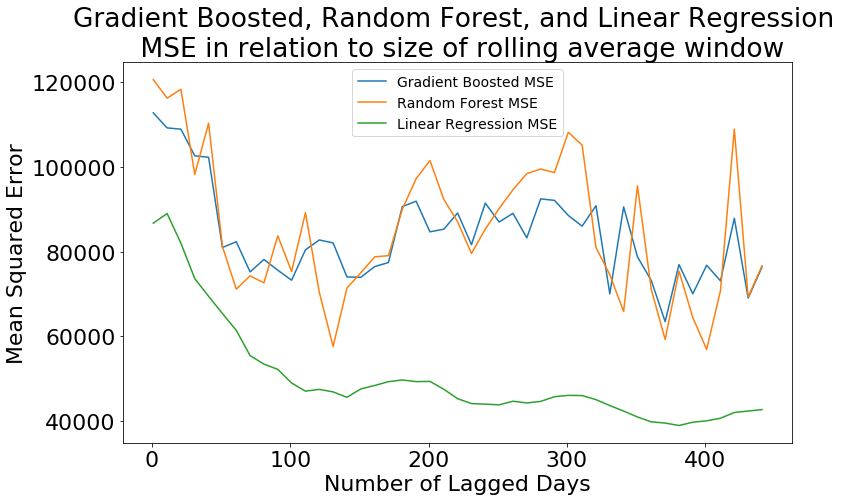

In [53]:
fig, ax= plt.subplots(figsize=(12,7))
ax.plot(range_list, gbr_mse_list, label='Gradient Boosted MSE')
ax.plot(range_list,rf_mse_list, label= 'Random Forest MSE')
ax.plot(range_list, ridge_mse_list, label='Linear Regression MSE')

ax.set_title('Gradient Boosted, Random Forest, and Linear Regression \n MSE in relation to size of rolling average window')
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Number of Lagged Days')
ax.legend(prop={'size': 14})